#### Now integrating drone mechanisms ...

In [1]:
# Core utilities moved to fire_model package
import numpy as np
import matplotlib.pyplot as plt
from fire_model.ca import FireEnv, FireState, CAFireModel
from fire_model.boundary import (
    FireBoundary,
    between_boundaries_mask,
    candidates_from_mask,
    extract_fire_boundary,
    plot_fire_boundary,
)
from fire_model.harmonic import (
    HarmonicStripMap,
    BoundaryMap,
    build_harmonic_strip_map_uniform,
    plot_strip_map,
    sd_to_xy_theta,
    build_boundary_map,
    plot_boundary_correspondence,
)
from fire_model.bo import (
    RetardantDropBayesOpt,
    SearchGridProjector,
    TiedXYFiMatern,
    expected_improvement,
)


### Evolving fire with no retardant involved

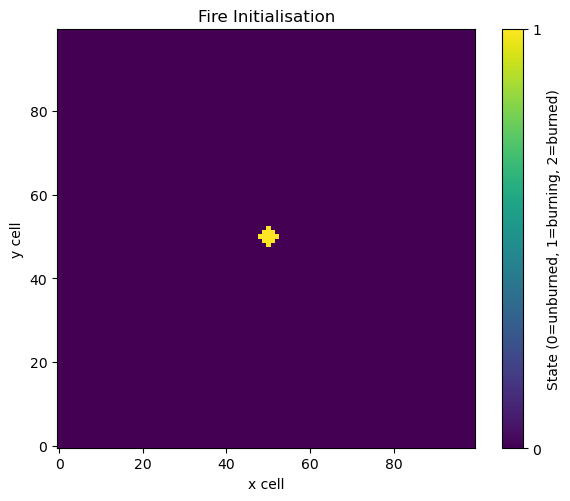

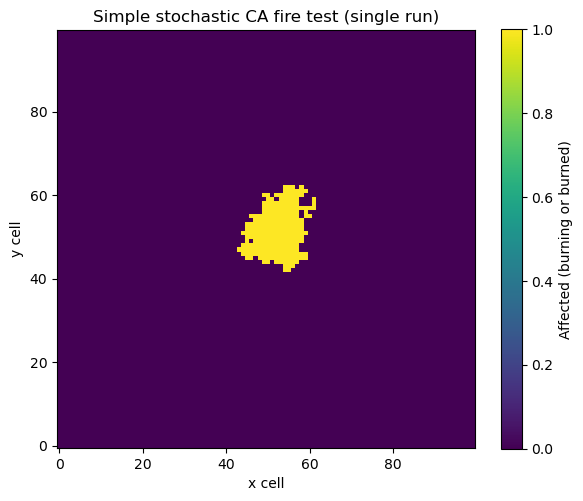

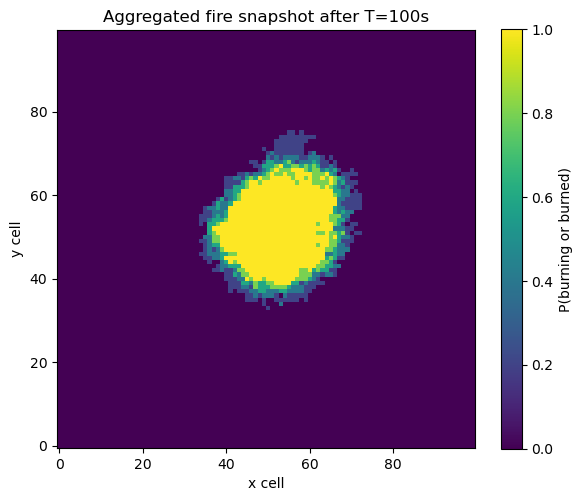

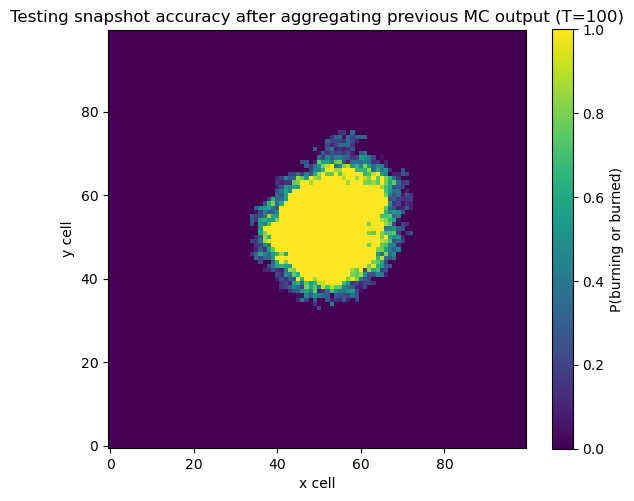

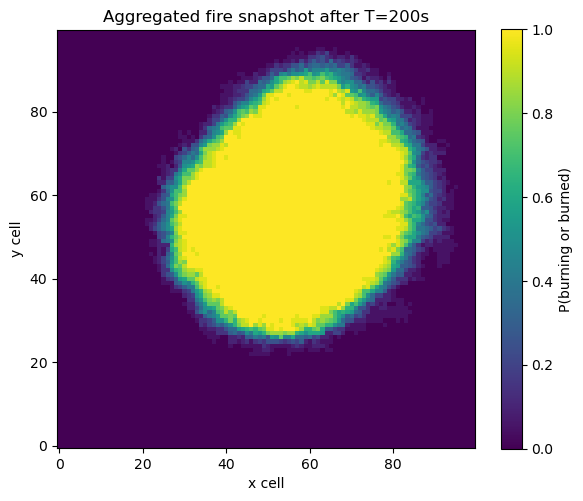

In [2]:
# Constant wind: mild south-westerly
wind=np.zeros((100, 100, 2))
wind[..., 0] = 2
wind[..., 1] = 2

default_env = FireEnv(
    grid_size=(100, 100),
    domain_km=10.0,
    fuel=np.ones((100, 100)),
    value=np.ones((100, 100)),
    wind=wind,
    burn_time_s0=300.0,
    dt_s=1.0,
)

model = CAFireModel(default_env, seed=123)

state = model.init_state_batch(n_sims=3, center=(50, 50), radius_km=0.2)

model.plot_firestate(state, title="Fire Initialisation")

for _ in range(60):
    model.step_batch(state, ros_mps=2, wind_coeff=0.6, diag=True)

model.plot_firestate(state,  kind="p_affected", title="Simple stochastic CA fire test (single run)")


fire_snapshot = model.simulate_from_ignition(
    T=100, n_sims=5, center=(50, 50), radius_km=0.4,
    ros_mps=2, wind_coeff=0.6, diag=True
)

model.plot_firestate(fire_snapshot, kind="p_affected", title="Aggregated fire snapshot after T=100s")

updated_fire_snapshot = model.simulate_from_firestate(
    fire_snapshot, T=0, n_sims=20, ros_mps=2, wind_coeff=0.6, diag=True
)

model.plot_firestate(updated_fire_snapshot, kind="p_affected", title="Testing snapshot accuracy after aggregating previous MC output (T=100)")

reupdated_fire_snapshot = model.simulate_from_firestate(
    updated_fire_snapshot, T=100, n_sims=20, ros_mps=2, wind_coeff=0.6, diag=True
)

model.plot_firestate(reupdated_fire_snapshot, kind="p_affected", title="Aggregated fire snapshot after T=200s")

with retardant barrier:


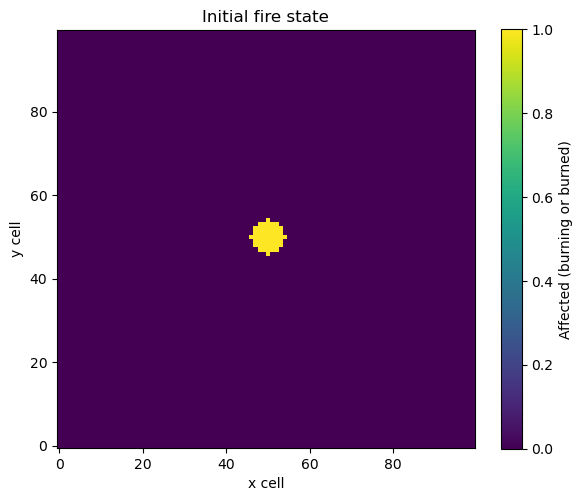

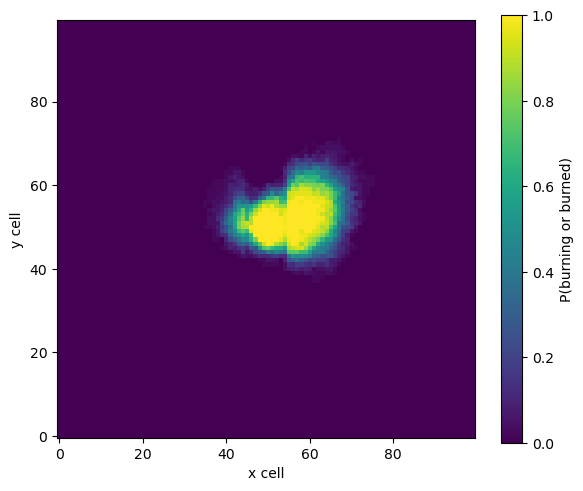

without retardant barrier:
with retardant barrier:


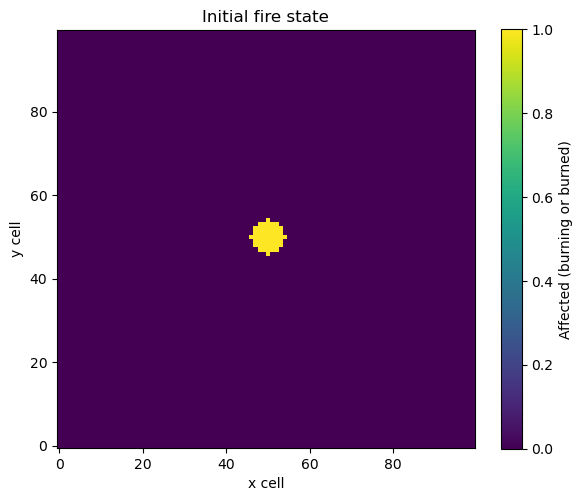

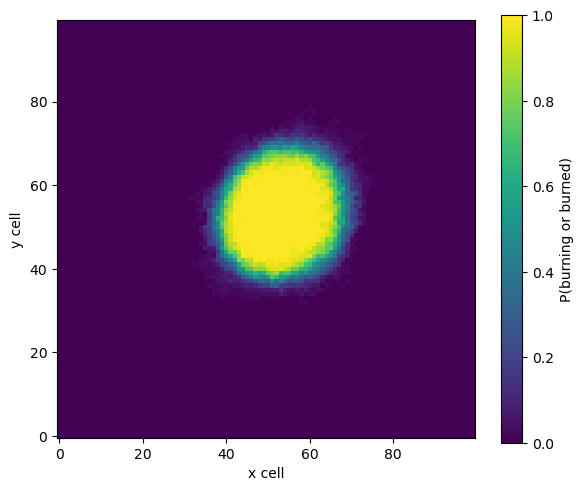

In [3]:
# Constant wind: mild south-westerly
wind=np.zeros((100, 100, 2))
wind[..., 0] = 2
wind[..., 1] = 2

default_env = FireEnv(
    grid_size=(100, 100),
    domain_km=10.0,
    fuel=np.ones((100, 100)),
    value=np.ones((100, 100)),
    wind=wind,
    burn_time_s0=300.0,
    dt_s=1.0,
    retardant_half_life_s = 100, #small for testing
    retardant_k = 1.0,          #strong for testing
)

model = CAFireModel(default_env, seed=123)

state = model.init_state_batch(n_sims=50, center=(50,50), radius_km=0.4)
state.retardant[:, 45:55, 20:80] = 2.0  # barrier

print('with retardant barrier:')
model.plot_firestate(state, kind="p_affected", title="Initial fire state")
#model.plot_firestate(state, kind="retardant", title="Initial retardant barrier")


for _ in range(100):
    model.step_batch(state, ros_mps=2.0, wind_coeff=0.6)

agg = model.aggregate_mc_to_state(state)
model.plot_firestate(agg, kind="p_affected")
#model.plot_firestate(agg, kind="retardant")

print('without retardant barrier:')

state = model.init_state_batch(n_sims=50, center=(50,50), radius_km=0.4)

print('with retardant barrier:')
model.plot_firestate(state, kind="p_affected", title="Initial fire state")

for _ in range(100):
    model.step_batch(state, ros_mps=2.0, wind_coeff=0.6)

agg = model.aggregate_mc_to_state(state)
model.plot_firestate(agg, kind="p_affected")

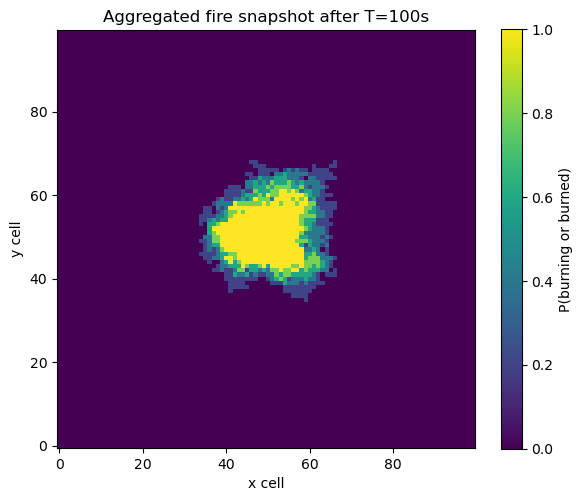

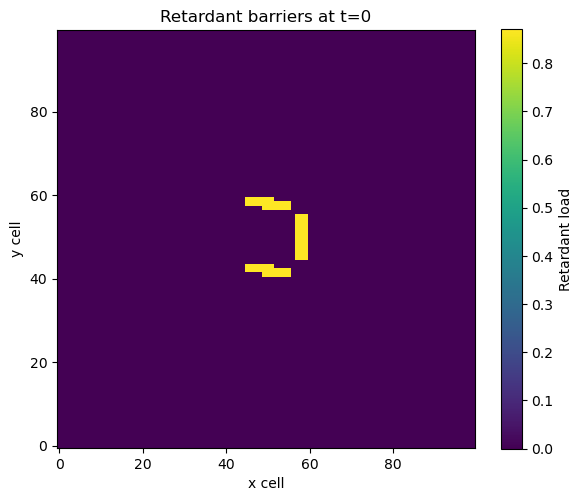

'updated_fire_snapshot = model.simulate_from_firestate(\n    fire_snapshot, T=0, n_sims=20, ros_mps=2, wind_coeff=0.6, diag=True\n)\n\nmodel.plot_firestate(updated_fire_snapshot, kind="p_affected", title="Aggregated fire snapshot after T=100s")\n\nreupdated_fire_snapshot = model.simulate_from_firestate(\n    updated_fire_snapshot, T=100, n_sims=20, ros_mps=2, wind_coeff=0.6, diag=True\n)\n\nmodel.plot_firestate(reupdated_fire_snapshot, kind="p_affected", title="Aggregated fire snapshot after T=200s")'

In [4]:
# phi=0 => vertical, phi=pi/2 => horizontal
drone_params = np.array([
    #[42.0, 50.0, 0.0],          # left vertical barrier
    [58.0, 50.0, 0.0],          # right vertical barrier
    [50.0, 58.0, np.pi/2],      # top horizontal barrier
    [50.0, 42.0, np.pi/2],      # bottom horizontal barrier
], dtype=float)

# Constant wind: mild south-westerly
wind=np.zeros((100, 100, 2))
wind[..., 0] = 1
wind[..., 1] = 1

default_env = FireEnv(
    grid_size=(100, 100),
    domain_km=10.0,
    fuel=np.ones((100, 100)),
    value=np.ones((100, 100)),
    wind=wind,
    burn_time_s0=300.0,
    dt_s=1.0,
    retardant_half_life_s = 500, #small for testing
    retardant_k = 1.0,          #strong for testing
)

model = CAFireModel(default_env, seed=123)
state = model.init_state_batch(n_sims=50, center=(50,50), radius_km=0.4)

fire_snapshot = model.simulate_from_ignition(
    T=100, n_sims=5, center=(50, 50), radius_km=0.4,
    ros_mps=2, wind_coeff=0.6, diag=True, drone_params=drone_params,
)

model.plot_firestate(fire_snapshot, kind="p_affected", title="Aggregated fire snapshot after T=100s")

model.plot_firestate(fire_snapshot, kind="retardant", title="Retardant barriers at t=0")


"""updated_fire_snapshot = model.simulate_from_firestate(
    fire_snapshot, T=0, n_sims=20, ros_mps=2, wind_coeff=0.6, diag=True
)

model.plot_firestate(updated_fire_snapshot, kind="p_affected", title="Aggregated fire snapshot after T=100s")

reupdated_fire_snapshot = model.simulate_from_firestate(
    updated_fire_snapshot, T=100, n_sims=20, ros_mps=2, wind_coeff=0.6, diag=True
)

model.plot_firestate(reupdated_fire_snapshot, kind="p_affected", title="Aggregated fire snapshot after T=200s")"""

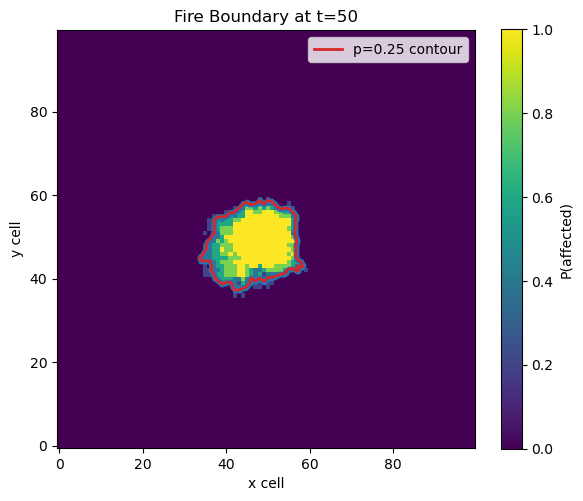

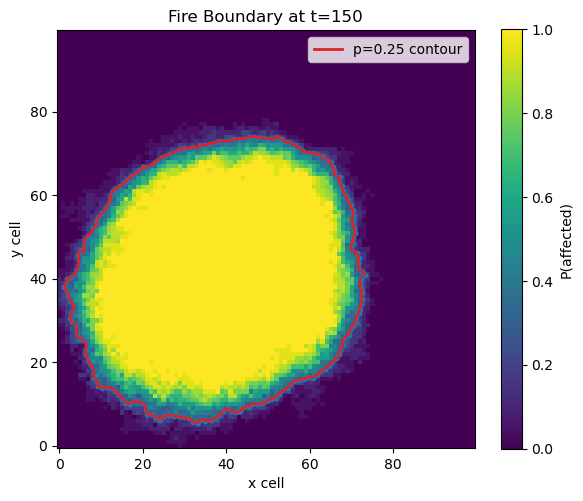

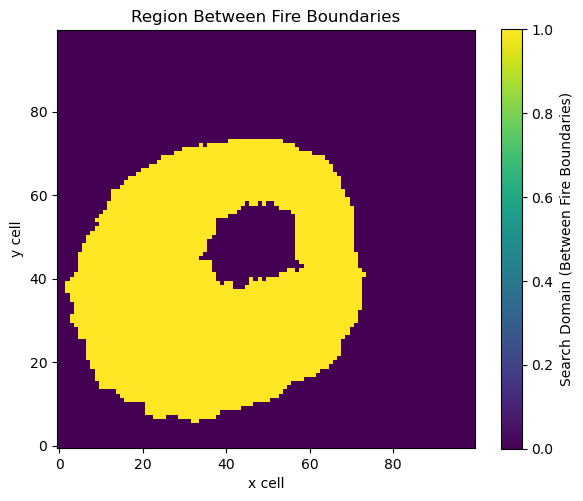

In [5]:
# phi=0 => vertical, phi=pi/2 => horizontal
drone_params = np.array([
    #[42.0, 50.0, 0.0],          # left vertical barrier
    [58.0, 50.0, 0.0],          # right vertical barrier
    [50.0, 58.0, np.pi/2],      # top horizontal barrier
    [50.0, 42.0, np.pi/2],      # bottom horizontal barrier
], dtype=float)

# Constant wind: mild south-westerly
wind=np.zeros((100, 100, 2))
wind[..., 0] = -3
wind[..., 1] = -3

default_env = FireEnv(
    grid_size=(100, 100),
    domain_km=10.0,
    fuel=np.ones((100, 100)),
    value=np.ones((100, 100)),
    wind=wind,
    burn_time_s0=300.0,
    dt_s=1.0,
    retardant_half_life_s = 500, #small for testing
    retardant_k = 1.0,          #strong for testing
)

model = CAFireModel(default_env, seed=123)
state = model.init_state_batch(n_sims=50, center=(50,50), radius_km=0.4)

fire_evolved = model.simulate_from_ignition(
    T=50, n_sims=5, center=(50, 50), radius_km=0.4,
    ros_mps=2, wind_coeff=0.6, diag=True, drone_params=drone_params,
)

init_boundary = extract_fire_boundary(
    fire_evolved,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    fire_evolved,
    init_boundary,
    field="affected",
    title="Fire Boundary at t=50"
)

updated_fire = model.simulate_from_firestate(
    fire_evolved, T=150, n_sims=20, ros_mps=2, wind_coeff=0.6, diag=True
)

final_boundary = extract_fire_boundary(
    updated_fire,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    updated_fire,
    final_boundary,
    field="affected",
    title="Fire Boundary at t=150"
)

x = model.discretise_between_boundaries(
    init_fire_boundary=init_boundary,
    final_fire_boundary=final_boundary)

model.plot_search_domain(x)

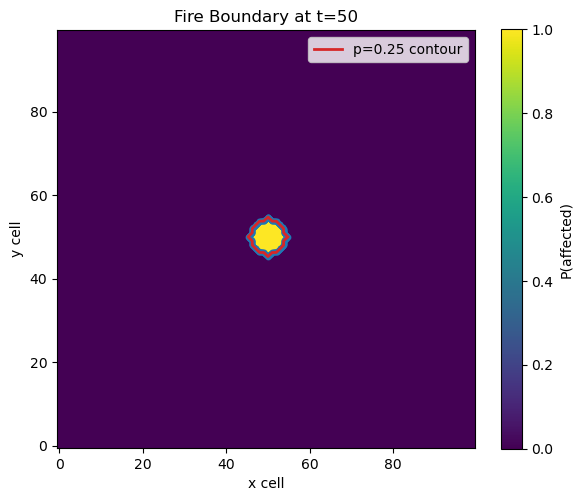

In [6]:
### Testing that fire boundary works at initialisation
model = CAFireModel(default_env, seed=123)
state = model.init_state_batch(n_sims=50, center=(50,50), radius_km=0.4)

init_boundary = extract_fire_boundary(
    state,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    state,
    init_boundary,
    field="affected",
    title="Fire Boundary at t=50"
)

### Testing Basic BO Loop:

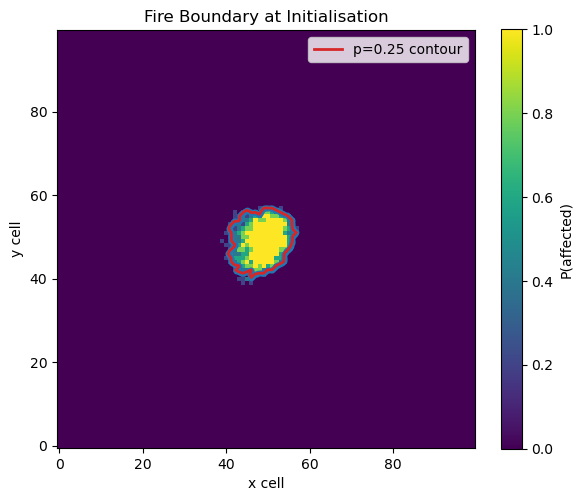

[BO] Search grid set up with 446 valid cells in grid.


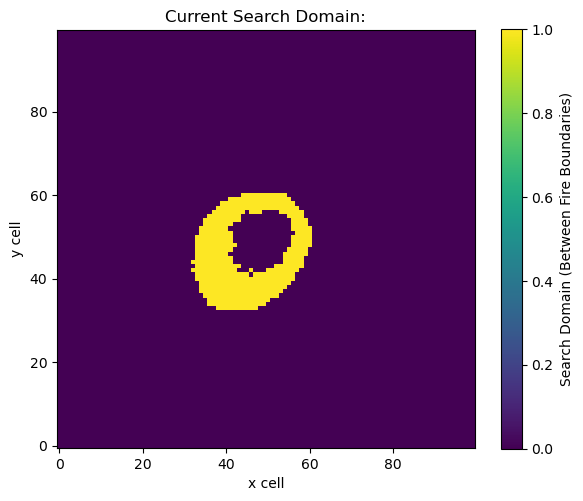

In [ ]:
# Constant wind: mild south-westerly
wind=np.zeros((100, 100, 2))
wind[..., 0] = -3
wind[..., 1] = -3

default_env = FireEnv(
    grid_size=(100, 100),
    domain_km=10.0,
    fuel=np.ones((100, 100)),
    value=np.ones((100, 100)),
    wind=wind,
    burn_time_s0=300.0,
    dt_s=1.0,
    retardant_half_life_s = 500, #small for testing
    retardant_k = 5.0,          #strong for testing
)

model = CAFireModel(default_env, seed=123)
state = model.init_state_batch(n_sims=50, center=(50,50), radius_km=0.4)

init_firestate = model.simulate_from_ignition(
    T=25, n_sims=5, center=(50, 50), radius_km=0.4,
    ros_mps=2, wind_coeff=0.6, diag=True
)

init_boundary = extract_fire_boundary(
    init_firestate,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    init_firestate,
    init_boundary,
    field="affected",
    title="Fire Boundary at Initialisation"
)

bo = RetardantDropBayesOpt(
    fire_model=model,
    init_firestate=init_firestate,
    evolution_time_s=150.0,
    n_sims=50,
    n_drones=4,
    fire_boundary_probability=0.25,
)

best_theta, best_params, best_obj, (X, y), y_nexts, y_bests = bo.run_bayes_opt(
    n_init=15,
    n_iters=40,
    n_candidates=10000,
    xi=0.01,
    K_grid=500,
    boundary_field="affected",
    verbose=True,
)

print("best objective:", best_obj)
print("best (x,y,phi) per drone:\n", best_params)


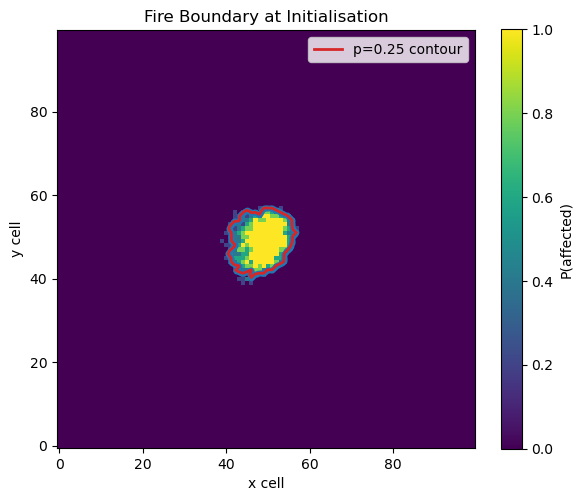

AttributeError: 'RetardantDropBayesOpt' object has no attribute 'run_random_search'

In [ ]:
best_theta, best_params, best_obj, (X, y), y_nexts, y_bests = bo.run_random_search(
    n_evals=50,        
    K_grid=500,        
    boundary_field="affected",
    verbose=True,
    print_every=5,
)

print("best objective:", best_obj)
print("best (x,y,phi) per drone:\n", best_params)

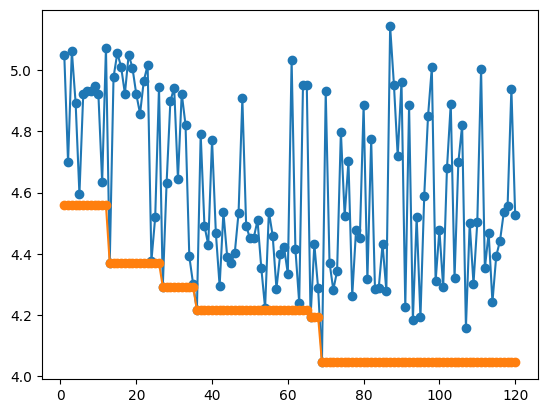

In [ ]:
plt.plot(np.arange(1, len(y_nexts)+1), y_nexts, 'o-', label='y_nexts')
plt.plot(np.arange(1, len(y_bests)+1), y_bests, 'o-', label='y_bests')

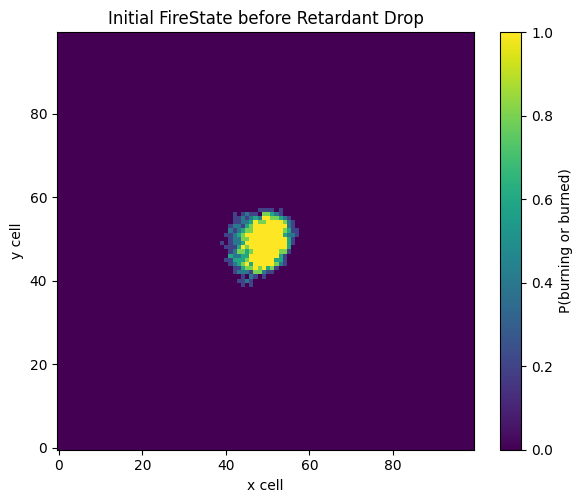

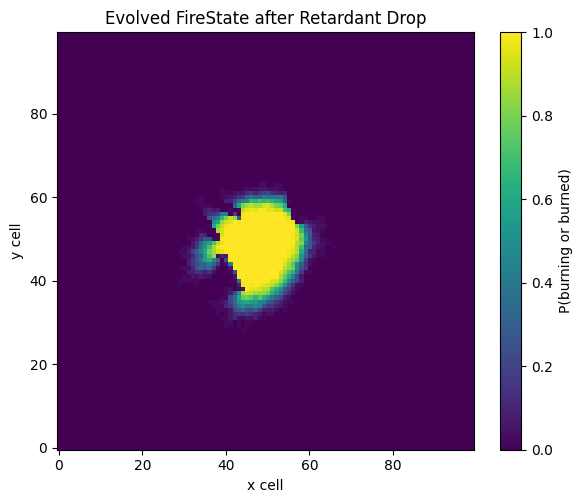

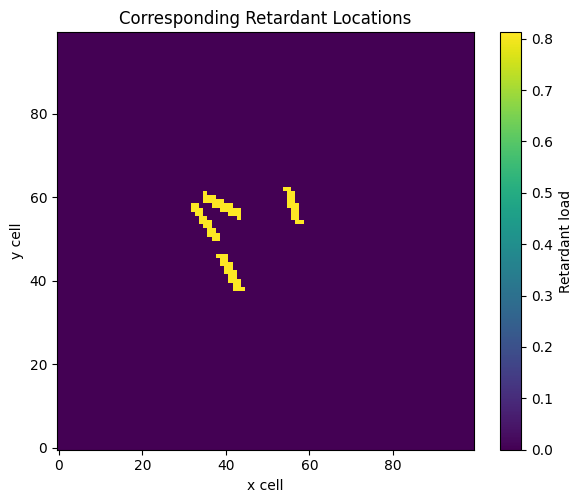

In [ ]:
bo.plot_evolved_firestate(
    theta=best_theta,
    n_sims=50,)

### Fire Boundary Mechanisms (currently in draft)

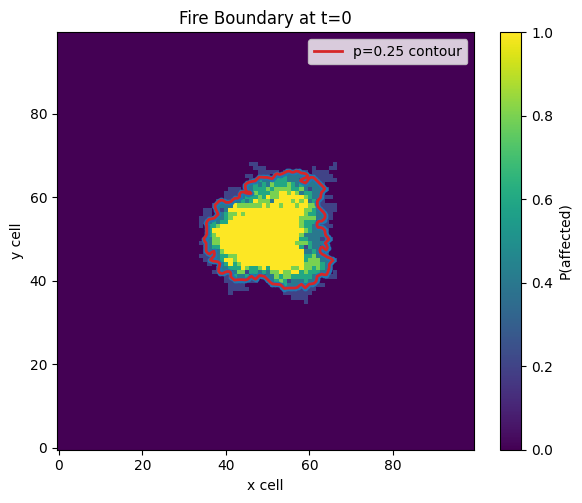

In [ ]:
extracted_boundary = extract_fire_boundary(
    fire_snapshot,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    fire_snapshot,
    extracted_boundary,
    field="affected",
    title="Fire Boundary at t=0"
)

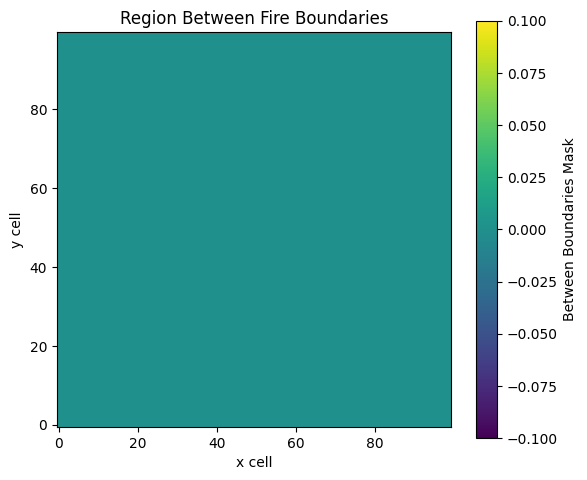

In [ ]:
x = model.discretise_between_boundaries(
    init_fire_boundary=extracted_boundary,
    final_fire_boundary=extracted_boundary)

#plot a 2d map of the region between boundaries
plt.figure(figsize=(6, 5))
im = plt.imshow(x.T, origin="lower", aspect="equal")
plt.colorbar(im, label="Between Boundaries Mask")
plt.xlabel("x cell")
plt.ylabel("y cell")
plt.title("Region Between Fire Boundaries")
plt.tight_layout()
plt.show()

#### Fire boundary map (connecting between fire boundaries)

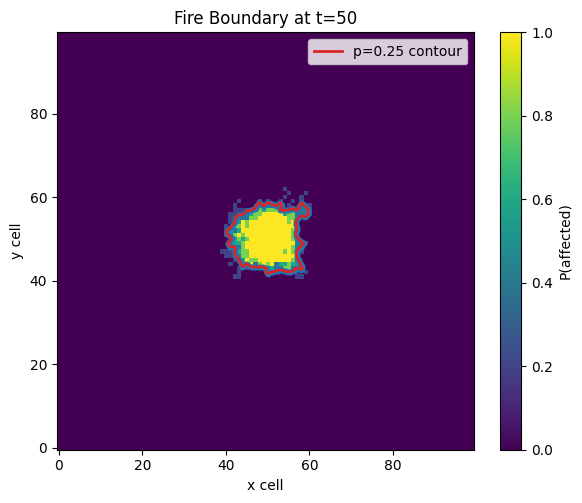

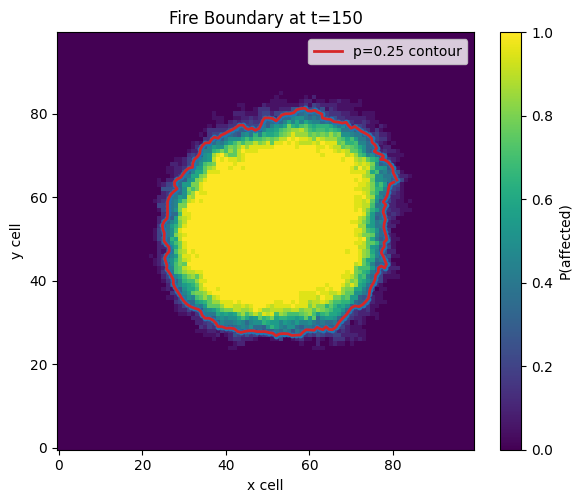

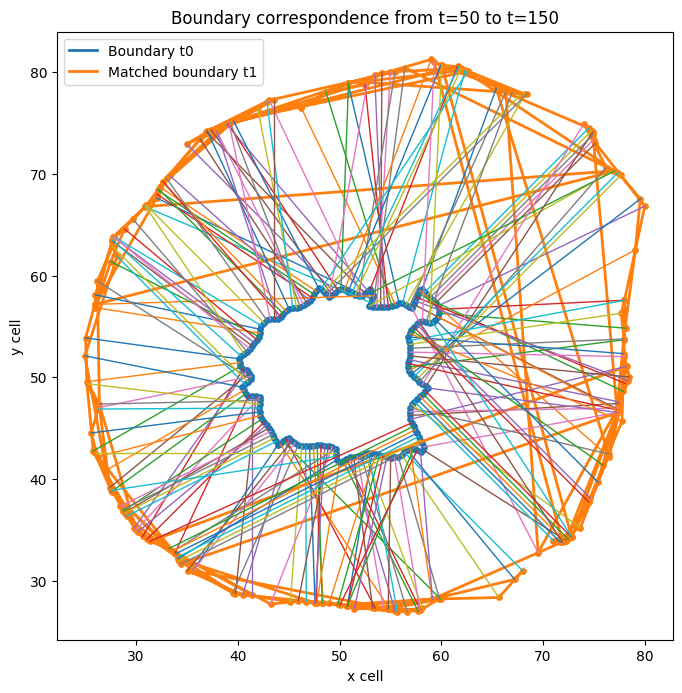

BoundaryMap(t0=50, t1=200, K=200, p_boundary=0.25, s=array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
       0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
       0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
       0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  ,
       0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445,
       0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
       0.495, 0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535,
       0.54 , 0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 ,
       0.585, 0.59 , 0.595, 0.6  , 0.

In [ ]:
# phi=0 => vertical, phi=pi/2 => horizontal
drone_params = np.array([
    #[42.0, 50.0, 0.0],          # left vertical barrier
    [58.0, 50.0, 0.0],          # right vertical barrier
    [50.0, 58.0, np.pi/2],      # top horizontal barrier
    [50.0, 42.0, np.pi/2],      # bottom horizontal barrier
], dtype=float)

# Constant wind: mild south-westerly
wind=np.zeros((100, 100, 2))
wind[..., 0] = 1
wind[..., 1] = 1

default_env = FireEnv(
    grid_size=(100, 100),
    domain_km=10.0,
    fuel=np.ones((100, 100)),
    value=np.ones((100, 100)),
    wind=wind,
    burn_time_s0=300.0,
    dt_s=1.0,
    retardant_half_life_s = 500, #small for testing
    retardant_k = 1.0,          #strong for testing
)

model = CAFireModel(default_env, seed=123)
state = model.init_state_batch(n_sims=50, center=(50,50), radius_km=0.4)

fire_evolved = model.simulate_from_ignition(
    T=50, n_sims=5, center=(50, 50), radius_km=0.4,
    ros_mps=2, wind_coeff=0.6, diag=True, drone_params=drone_params,
)

init_boundary = extract_fire_boundary(
    fire_evolved,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    fire_evolved,
    init_boundary,
    field="affected",
    title="Fire Boundary at t=50"
)

updated_fire = model.simulate_from_firestate(
    fire_evolved, T=150, n_sims=20, ros_mps=2, wind_coeff=0.6, diag=True
)

final_boundary = extract_fire_boundary(
    updated_fire,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)


plot_fire_boundary(
    updated_fire,
    final_boundary,
    field="affected",
    title="Fire Boundary at t=150"
)

plot_boundary_correspondence(
    init_boundary,
    final_boundary,
    stride=1,
    show_points=True,
    title="Boundary correspondence from t=50 to t=150"
)

#model.plot_firestate(fire_evolved, kind="p_affected", title="Fire at t=50")

#model.plot_firestate(updated_fire, kind="p_affected", title="Fire at t=150")

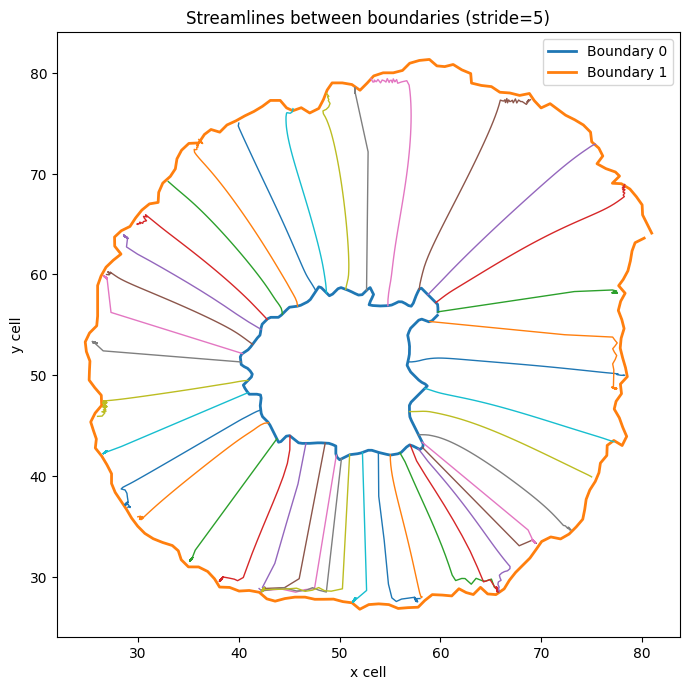

(array([77.029813  , 58.17954012]), np.float64(-1.5707963754714482))

In [ ]:
# boundary0 = extract_fire_boundary(fire0, K=200, p_boundary=0.5, anchor="max_x", ccw=True)
# boundary1 = extract_fire_boundary(fire1, K=200, p_boundary=0.5, anchor="max_x", ccw=True)

strip = build_harmonic_strip_map_uniform(
    init_boundary, final_boundary,
    grid_size=model.env.grid_size,   # important: use your env grid
    M=60,
    seed_mode="equal_flux",
    streamline_step=0.5,
)

plot_strip_map(init_boundary, final_boundary, strip, stride_s=5, show_psi=False)

# Query example
xy,theta = sd_to_xy_theta(strip, s=0, d=1)     # (2,) point in cell coords

xy,theta

In [ ]:
# boundary0 = extract_fire_boundary(fire0, K=200, p_boundary=0.5, anchor="max_x", ccw=True)
# boundary1 = extract_fire_boundary(fire1, K=200, p_boundary=0.5, anchor="max_x", ccw=True)

bm = build_boundary_map(init_boundary, final_boundary)

# Query a point halfway between boundaries at s=0.3
xy = bm.xy(s_query=0.3, d_query=0.5)      # returns shape (2,) here
theta = bm.theta(0.3)                      # orientation, 0=vertical

# Discrete velocity at the K sample points (future use)
v_i = bm.p1 - bm.p0                        # (K,2)
theta_i = bm.theta_i                       # (K,)